In [237]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [238]:
import time
import copy
import numpy as np
import tqdm
import joblib
import os
import lsst

import pytest
from astropy.table import Table

from metadetect.lsst.metadetect import run_metadetect
import descwl_shear_sims as sim
import matplotlib.pyplot as plt
plt.style.use("MNRAS")

In [239]:
CONFIG = {
    "meas_type": "wmom",
    "metacal": {
        'psf': 'fitgauss',
        'types': ['noshear', '1p', '1m', '2p', '2m'],
    },
    "psf": {
        "model": "gauss",
        "lm_pars": {},
        "ntry": 2,
    },
    "weight": {
        "fwhm": 1.2,
    },
    "detect": {
        "thresh": 10.0,
    },
}

In [240]:
def calculate_angle(x, y):
    """
    Calculate the angle from the positive x-axis to the point (x, y)
    in a counterclockwise direction.
    
    Args:
    x (float): The x-coordinate of the point.
    y (float): The y-coordinate of the point.
    
    Returns:
    float: The angle in degrees.
    """
    angle_radians = np.arctan2(y, x)
    angle_degrees = np.degrees(angle_radians)

    angle_degrees_positive = np.where(angle_degrees < 0, angle_degrees + 360, angle_degrees)

    
    # Ensure the angle is in the range [0, 360)
    # if angle_degrees < 0:
    #     angle_degrees += 360
    
    return angle_degrees_positive

In [241]:
def _shear_cuts(arr):
    assert arr is not None
    msk = (
        (arr["wmom_flags"] == 0) & (arr["wmom_s2n"] > 10) & (arr["wmom_T_ratio"] > 1.2)
    )
    return msk


def _meas_shear_data(res, radial_masks, angular_masks):
    # need to rotate the shear into the correct coordinate system
    # and calculate tangential shear
    
    # five radial masks are noshear 1p 1m 2p 2m

    msk = _shear_cuts(res["noshear"])
    msk = msk & radial_masks[0] & angular_masks[0]
    print(f"There are {np.sum(msk)} galaxies in the bin")
    
    col = res["noshear"]["col"]
    row = res["noshear"]["row"]
    theta = calculate_angle(col - 255., row - 255.)
    print(f"theta max is {np.max(theta)}")
    print(f"theta min is {np.min(theta)}")
    project_gt = - res["noshear"]["wmom_g"][:, 0] * np.cos(2 * np.radians(theta)) - res["noshear"][
        "wmom_g"][:, 1] * np.sin(2 * np.radians(theta))

    g1 = np.mean(res["noshear"]["wmom_g"][msk, 0])
    g2 = np.mean(res["noshear"]["wmom_g"][msk, 1])
    mean_gt = np.mean(project_gt[msk])

    # def _get_gt(g1, g2, theta):
    #     return g1 * np.cos(2 * theta) + g2 * np.sin(2 * theta)

    #need to rotate everything into the frame of cluster
    
    msk = _shear_cuts(res["1p"])
    msk = msk & radial_masks[1] & angular_masks[1]
    assert np.sum(msk) > 0
    g1_1p = np.mean(res["1p"]["wmom_g"][msk, 0])

    msk = _shear_cuts(res["1m"])
    msk = msk & radial_masks[2] & angular_masks[2]
    assert np.sum(msk) > 0
    g1_1m = np.mean(res["1m"]["wmom_g"][msk, 0])

    msk = _shear_cuts(res["1p"])
    msk = msk & radial_masks[1] & angular_masks[1]
    assert np.sum(msk) > 0
    g2_1p = np.mean(res["1p"]["wmom_g"][msk, 1])

    msk = _shear_cuts(res["1m"])
    msk = msk & radial_masks[2] & angular_masks[2]
    assert np.sum(msk) > 0
    g2_1m = np.mean(res["1m"]["wmom_g"][msk, 1])

    msk = _shear_cuts(res["2p"])
    msk = msk & radial_masks[3] & angular_masks[3]
    assert np.sum(msk) > 0
    g1_2p = np.mean(res["2p"]["wmom_g"][msk, 0])

    msk = _shear_cuts(res["2m"])
    msk = msk & radial_masks[4] & angular_masks[4]
    assert np.sum(msk) > 0
    g1_2m = np.mean(res["2m"]["wmom_g"][msk, 0])

    msk = _shear_cuts(res["2p"])
    msk = msk & radial_masks[3] & angular_masks[3]
    assert np.sum(msk) > 0
    g2_2p = np.mean(res["2p"]["wmom_g"][msk, 1])

    msk = _shear_cuts(res["2m"])
    msk = msk & radial_masks[4] & angular_masks[4]
    assert np.sum(msk) > 0
    g2_2m = np.mean(res["2m"]["wmom_g"][msk, 1])

    R11 = (g1_1p - g1_1m) / 0.02
    R22 = (g2_2p - g2_2m) / 0.02
    R12 = (g1_2p - g1_2m) / 0.02
    R21 = (g2_1p - g2_1m) / 0.02


    # Rt = (
    #     R11 * np.cos(2 * theta) ** 2
    #     + R22 * np.sin(2 * theta) ** 2
    #     + (R12 + R21) * np.sin(2 * theta) * np.cos(2 * theta)
    # )

    dt = [
        ("g1", "f8"),
        ("g2", "f8"),
        ("R11", "f8"),
    ]
    return np.array([(g1, g2, mean_gt, R11, R12, R21, R22)])


def _bootstrap_stat(d1, d2, func, seed, nboot=500):
    dim = d1.shape[0]
    rng = np.random.RandomState(seed=seed)
    stats = []
    for _ in tqdm.trange(nboot, leave=False):
        ind = rng.choice(dim, size=dim, replace=True)
        stats.append(func(d1[ind], d2[ind]))
    return stats


def _meas_m_c_cancel(pres, mres):
    x = np.mean(pres["g1"] - mres["g1"]) / 2
    y = np.mean(pres["R11"] + mres["R11"]) / 2
    m = x / y / 0.02 - 1

    x = np.mean(pres["g2"] + mres["g2"]) / 2
    y = np.mean(pres["R11"] + mres["R11"]) / 2
    c = x / y

    return m, c


def _boostrap_m_c(pres, mres):
    m, c = _meas_m_c_cancel(pres, mres)
    bdata = _bootstrap_stat(pres, mres, _meas_m_c_cancel, 14324, nboot=500)
    merr, cerr = np.std(bdata, axis=0)
    return m, merr, c, cerr

In [242]:
!export CATSIM_DIR=/path/to/catsim
from xlens.simulation.simulator.base import SimulateImageHalo
import astropy.table as astable
import fitsio

In [243]:
# Prepare a halo
src_halo = astable.Table()
src_halo["index"] = np.array([1, 2])
src_halo["mass"] = np.array([4e14, 8e14])
src_halo["conc"] = np.array([6.0, 4.0])
src_halo["z_lens"] = np.array([0.2, 0.52])

In [244]:
simulator = SimulateImageHalo("/global/cfs/cdirs/des/zhou/cluster_shear/repos/xlens/examples/cluster/config.ini")

with open("/global/cfs/cdirs/des/zhou/cluster_shear/repos/xlens/examples/cluster/config.ini", "r") as f:
    contents = f.read()
    print(contents)

import os 
os.environ['CATSIM_DIR'] = '/global/cfs/cdirs/des/zhou/cluster_shear/data/catsim'

simulator.run(ifield=1, src_halo=src_halo[0])

[simulation]
root_dir    =   ./
# image directory name
sim_name    =   sim
# catalog directory name
cat_dir     =   test
sum_dir     =   test

# layout
layout = random_disk
# number of rotation
nrot = 2
# number of pixels
coadd_dim = 500
# buff on each side
buff = 20

rotate = False
dither = False

draw_bright = False
star_bleeds = False
cosmic_rays = False
bad_columns = False

psf_variation = 0.0
stellar_density = 0.0
survey_name = LSST

band        =   r
noise_ratio =   1.0
psf_fwhm    =   0.8

Simulating for field: 1, and halo index 1
Simulation has galaxies: 435
Halo at galsim.PositionD(0.0,0.0)
redshift forced to 1.0
redshift forced to 1.0
redshift forced to 1.0
redshift forced to 1.0
redshift forced to 1.0
redshift forced to 1.0
redshift forced to 1.0
redshift forced to 1.0
redshift forced to 1.0
redshift forced to 1.0
redshift forced to 1.0
redshift forced to 1.0
redshift forced to 1.0
redshift forced to 1.0
redshift forced to 1.0
redshift forced to 1.0
redshift forced to 1.0
re

In [245]:
sim_data_list = simulator.sim_data_list
assert sim_data_list[0]['band_data']['i'][0].getPsf() is not None
print(len(sim_data_list))

2


In [246]:
exp = sim_data_list[0]['band_data']['i'][0]
sim_data = sim_data_list[0]

In [247]:
exp.getVariance()

lsst.afw.image._image.ImageF=[[0.35490522 0.35490522 0.35490522 ... 0.35490522 0.35490522 0.35490522]
 [0.35490522 0.35490522 0.35490522 ... 0.35490522 0.35490522 0.35490522]
 [0.35490522 0.35490522 0.35490522 ... 0.35490522 0.35490522 0.35490522]
 ...
 [0.35490522 0.35490522 0.35490522 ... 0.35490522 0.35490522 0.35490522]
 [0.35490522 0.35490522 0.35490522 ... 0.35490522 0.35490522 0.35490522]
 [0.35490522 0.35490522 0.35490522 ... 0.35490522 0.35490522 0.35490522]], bbox=(minimum=(0, 0), maximum=(509, 509))

In [248]:
from descwl_coadd.coadd_nowarp import make_coadd_nowarp

In [249]:
from metadetect.lsst.util import extract_multiband_coadd_data
raw_coadd_data = [make_coadd_nowarp(
    exp=exp,
    psf_dims=sim_data['psf_dims'],
    rng = np.random.RandomState(seed=116),
    remove_poisson=False,
)]

coadd_data = extract_multiband_coadd_data(raw_coadd_data)

In [250]:
mdet_rng = np.random.RandomState(seed=1234)
results = run_metadetect(
    rng=mdet_rng,
    config = copy.deepcopy(CONFIG),
    **coadd_data,
)

Exception in base_SkyCoord.measure on record 1: 
  File "src/table/Schema.cc", line 103, in lsst::afw::table::SchemaItem<T> lsst::afw::table::detail::SchemaImpl::find(const std::string&) const [with T = float; std::string = std::__cxx11::basic_string<char>]
    Field with name 'coord_raErr' not found with type 'F'. {0}
lsst::pex::exceptions::NotFoundError: 'Field with name 'coord_raErr' not found with type 'F'.'

Exception in base_SkyCoord.measure on record 2: 
  File "src/table/Schema.cc", line 103, in lsst::afw::table::SchemaItem<T> lsst::afw::table::detail::SchemaImpl::find(const std::string&) const [with T = float; std::string = std::__cxx11::basic_string<char>]
    Field with name 'coord_raErr' not found with type 'F'. {0}
lsst::pex::exceptions::NotFoundError: 'Field with name 'coord_raErr' not found with type 'F'.'

Exception in base_SkyCoord.measure on record 3: 
  File "src/table/Schema.cc", line 103, in lsst::afw::table::SchemaItem<T> lsst::afw::table::detail::SchemaImpl::find

In [251]:
results.keys()

dict_keys(['noshear', '1p', '1m', '2p', '2m'])

In [252]:
mdet_keys = results.keys()
mdet_tables = [Table(results[key]) for key in mdet_keys]
mdet_tables_masked = [t[_shear_cuts(t)] for t in mdet_tables]

In [253]:
mdet_tables[0]

wmom_flags,wmom_psf_flags,wmom_psf_g,wmom_psf_T,wmom_obj_flags,wmom_s2n,wmom_g,wmom_g_cov,wmom_T,wmom_T_flags,wmom_T_err,wmom_T_ratio,wmom_band_flux_flags,wmom_band_flux,wmom_band_flux_err,shear_bands,stamp_size,row0,col0,row,col,row_diff,col_diff,ra,dec,psfrec_flags,psfrec_g,psfrec_T,bmask,ormask,mfrac
int32,int32,float64[2],float64,int32,float64,float64[2],"float64[2,2]",float64,int32,float64,float64,int32,float64,float64,str6,int32,int32,int32,float32,float32,float32,float32,float64,float64,int32,float64[2],float64,int32,int32,float32
1048576,1,nan .. nan,nan,1,nan,nan .. nan,nan .. nan,nan,1,nan,nan,1,nan,nan,nan,32,0,0,6.0,168.0,0.0,0.0,200.03252777926676,-0.07208330589354423,0,-3.1321435320869822e-06 .. -3.1128672525364853e-06,0.3222457913276844,0,0,0.0
1048576,1,nan .. nan,nan,1,nan,nan .. nan,nan .. nan,nan,1,nan,nan,1,nan,nan,nan,32,0,0,6.0,354.0,0.0,0.0,200.02219443808406,-0.07208330581161645,0,-3.1321435320869822e-06 .. -3.1128672525364853e-06,0.3222457913276844,0,0,0.0
1048576,1,nan .. nan,nan,1,nan,nan .. nan,nan .. nan,nan,1,nan,nan,1,nan,nan,nan,32,0,0,12.891304,326.33078,-0.10869562,0.33079246,200.0237316174695,-0.07170045575152194,0,-3.1321435320869822e-06 .. -3.1128672525364853e-06,0.3222457913276844,0,0,0.0
0,0,-1.6677627963683846e-08 .. 4.482619375372501e-09,0.18533281467341325,0,13.194672246017625,0.02942141691691601 .. 0.25003578789248193,0.014783120720949769 .. 0.016602796487803936,0.16200968750665898,0,0.02102719972968475,0.8741554364894666,0,50.2039953521773,3.804868693675185,0,32,0,0,15.693872,222.7613,-0.30612722,-0.23869246,200.02948548207783,-0.07154475765563328,0,-3.1321435320869822e-06 .. -3.1128672525364853e-06,0.3222457913276844,0,0,0.0
0,0,-1.166560709422572e-08 .. 1.6247485989768453e-08,0.18533281305262547,0,11.286276627938513,0.2767950529523579 .. -0.07063022110899564,0.010711721203776803 .. 0.009381116850115463,0.23873982853861514,0,0.0230836468523214,1.2881681587103773,0,42.94280090173461,3.804868719541415,0,32,0,0,23.148472,134.23303,0.14847173,0.23303843,200.03440372287434,-0.07113061284160425,0,-3.1321435320869822e-06 .. -3.1128672525364853e-06,0.3222457913276844,0,0,0.0
0,0,-3.9378097143364206e-09 .. -1.97369326518299e-08,0.18533281310055502,0,18.744664509273417,0.08022396167726234 .. -0.11319086659967487,0.0024063288989455297 .. 0.0024366258174271698,0.2842294743484923,0,0.013915556852431359,1.5336165765437306,0,71.32098763529447,3.8048687187765,0,32,0,0,52.134975,416.54922,0.13497388,-0.4507692,200.01871947863413,-0.06952025130741739,0,-3.1321435320869822e-06 .. -3.1128672525364853e-06,0.3222457913276844,0,0,0.0
0,0,-7.156362196063835e-09 .. -1.460673986088857e-08,0.18533281530398654,0,36.63585893286247,0.10743852885428032 .. 0.09437143869091859,0.00066325147979099 .. 0.0006598323345458927,0.2783925691823555,0,0.007106645691414657,1.502122377657354,0,139.3946323508694,3.8048686836118377,0,32,0,0,55.503708,376.35565,0.5037067,0.35565415,200.02095245669614,-0.06933309986695983,0,-3.1321435320869822e-06 .. -3.1128672525364853e-06,0.3222457913276844,0,0,0.0
0,0,9.045494552954704e-10 .. -2.1724548094059752e-08,0.18533281231278265,0,12.309888286756724,-0.023213060331039266 .. -0.12719608979712757,0.004091323270875488 .. 0.004219162084430093,0.32998555273489244,0,0.02185499443866414,1.7805025921582742,0,46.83750902867495,3.804868731348592,0,32,0,0,68.02803,447.51944,0.028029764,-0.48057473,200.01699891126128,-0.06863730344575311,0,-3.1321435320869822e-06 .. -3.1128672525364853e-06,0.3222457913276844,0,0,0.0
0,0,-6.186565666021086e-09 .. -1.0548814334836387e-08,0.18533281771008683,0,33.02602807534583,0.02921271593931799 .. -0.021591919121357373,0.0009305024927324708 .. 0.0009297831917583109,0.2579896191231411,0,0.007863211453812554,1.392034191843509,0,125.6596986998002,3.8048686452127765,0,32,0,0,79.70086,351.29703,-0.29913744,0.2970341,200.0223446033602,-0.06798881365681404,0,-3.1321435320869822e-06 .. -3.1128672525364853e-06,0.3222457913276844,0,0,0.0


In [254]:
image = simulator.image_list[0]

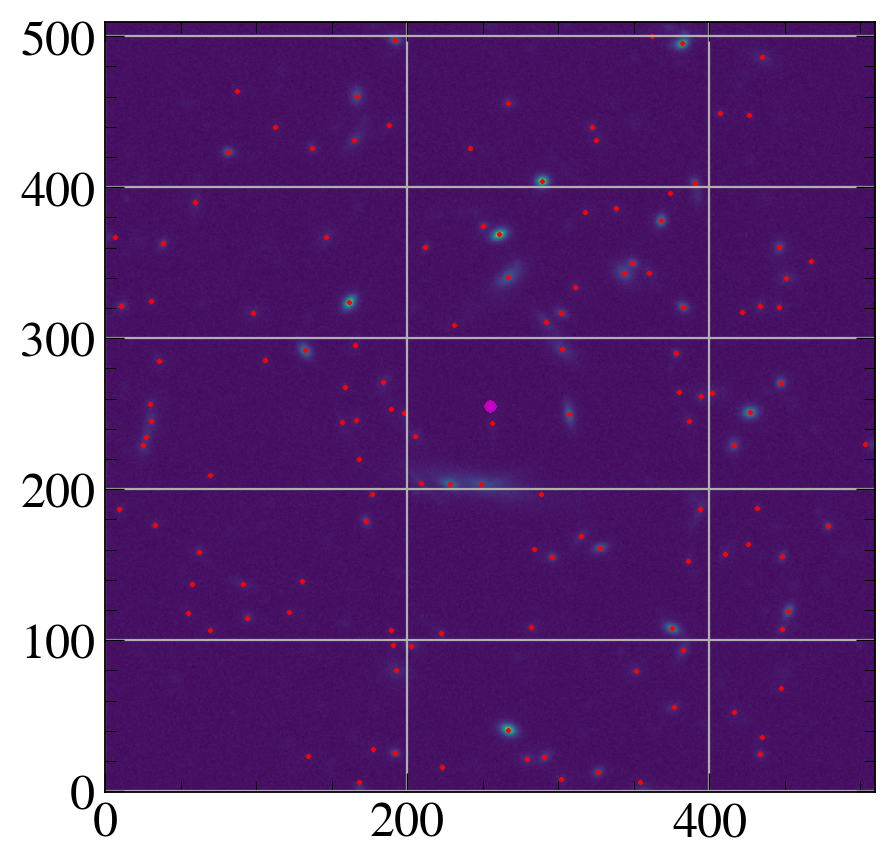

In [255]:
plt.imshow(image, origin='lower')
for i in range(len(mdet_tables[0])):
    coord_row, coord_col = mdet_tables[0][i]['row'], mdet_tables[0][i]['col']
    plt.scatter(coord_col, coord_row, color='r', s=1, marker="x")
    #draw a magenta circle at the center of the image 
    plt.scatter(image.shape[1]//2, image.shape[0]//2, color='m', s=10, marker="o")

In [256]:
# match object to input?
print(np.sqrt(250**2 + 250**2))
pixel_radial_bin_edges = np.array([0,100,200,300])

353.5533905932738


In [257]:
mid = image.shape[1]//2

/tmp/ipykernel_1278476/325004393.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(raw_coadd_data[0]['coadd_exp'].getImage().getArray()), origin='lower')


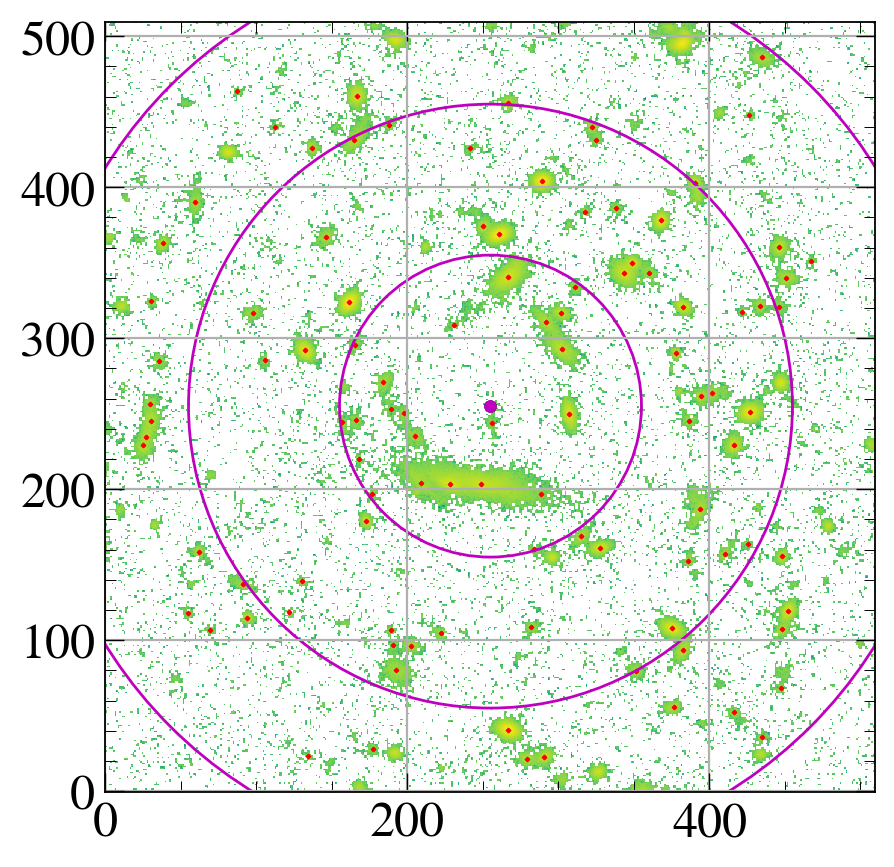

In [258]:
# plt.imshow(np.log10(image), origin='lower')

plt.imshow(np.log10(raw_coadd_data[0]['coadd_exp'].getImage().getArray()), origin='lower')
for i in range(len(mdet_tables_masked[0])):
    coord_row, coord_col = mdet_tables_masked[0][i]['row'], mdet_tables_masked[0][i]['col']
    plt.scatter(coord_col, coord_row, color='r', s=1, marker='x')
    plt.scatter(image.shape[1]//2, image.shape[0]//2, color='m', s=10, marker="o")
#draw three circles with radius 100, 200, 300
for radius in pixel_radial_bin_edges:
    circle = plt.Circle((image.shape[1]//2, image.shape[0]//2), radius, color='m', fill=False)
    plt.gca().add_artist(circle)

In [259]:
# match object to input?
print(np.sqrt(250**2 + 250**2))
pixel_radial_bins_edges = np.array([0,100,200,300])

353.5533905932738


In [260]:
# we can calculate g in each radial bin
# but we need to know the true input shear

In [261]:
# theory shear calculation 
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.LensModel.lens_model import LensModel
from astropy.cosmology import Planck18
import galsim

In [262]:
bin_mids = (pixel_radial_bin_edges[1:] + pixel_radial_bin_edges[:-1]) / 2
print(bin_mids)
lens = LensModel(lens_model_list=['NFW'])
reference_g1_list = []
pixel_scale = 0.2
for bin_mid in bin_mids:

    r = galsim.PositionD(bin_mid,0) * pixel_scale  # arcsec
    z_lens = 0.2
    z_source = 1.0
    lens_cosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=Planck18)
    rs_angle, alpha_rs = lens_cosmo.nfw_physical2angle(
        M=4e14, c=6.0
    )
    kwargs = [{"Rs": rs_angle, "alpha_Rs": alpha_rs}]
    f_xx, f_xy, f_yx, f_yy = lens.hessian(r.x, r.y, kwargs)
    gamma1 = 1.0 / 2 * (f_xx - f_yy)
    gamma2 = f_xy
    kappa = 1.0 / 2 * (f_xx + f_yy)

    g1 = gamma1 / (1 - kappa)
    g2 = gamma2 / (1 - kappa)
    mu = 1.0 / ((1 - kappa) ** 2 - gamma1**2 - gamma2**2)
    print(g1, g2, mu)
    reference_g1_list.append(g1)
    
# not sure about the sign convention here

[ 50. 150. 250.]
-0.3294258097953223 0.0 5.347894576379447
-0.1706641915427912 0.0 1.8596804260951763
-0.12590572483452334 0.0 1.4299960275002361


(array([11., 10.,  9., 22., 12., 17., 24., 16.,  6.,  5.]),
 array([127.47357941, 179.95053101, 232.42747498, 284.90441895,
        337.38137817, 389.85830688, 442.33526611, 494.81219482,
        547.28912354, 599.76611328, 652.24304199]),
 <BarContainer object of 10 artists>)

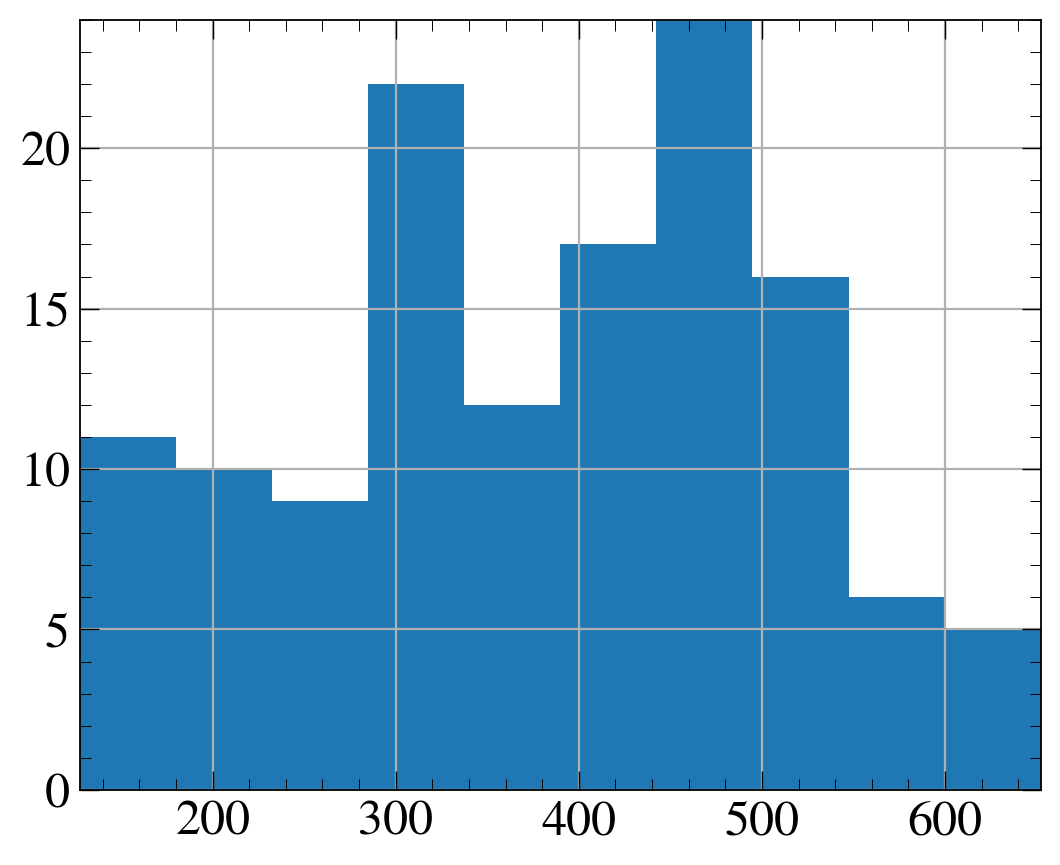

In [263]:
plt.hist(np.sqrt(mdet_tables[0]["row"] ** 2 + mdet_tables[0]["col"] ** 2))

In [264]:
len(results['noshear'])

132

In [265]:
results.keys()

dict_keys(['noshear', '1p', '1m', '2p', '2m'])

In [266]:
len(mdet_tables)

5

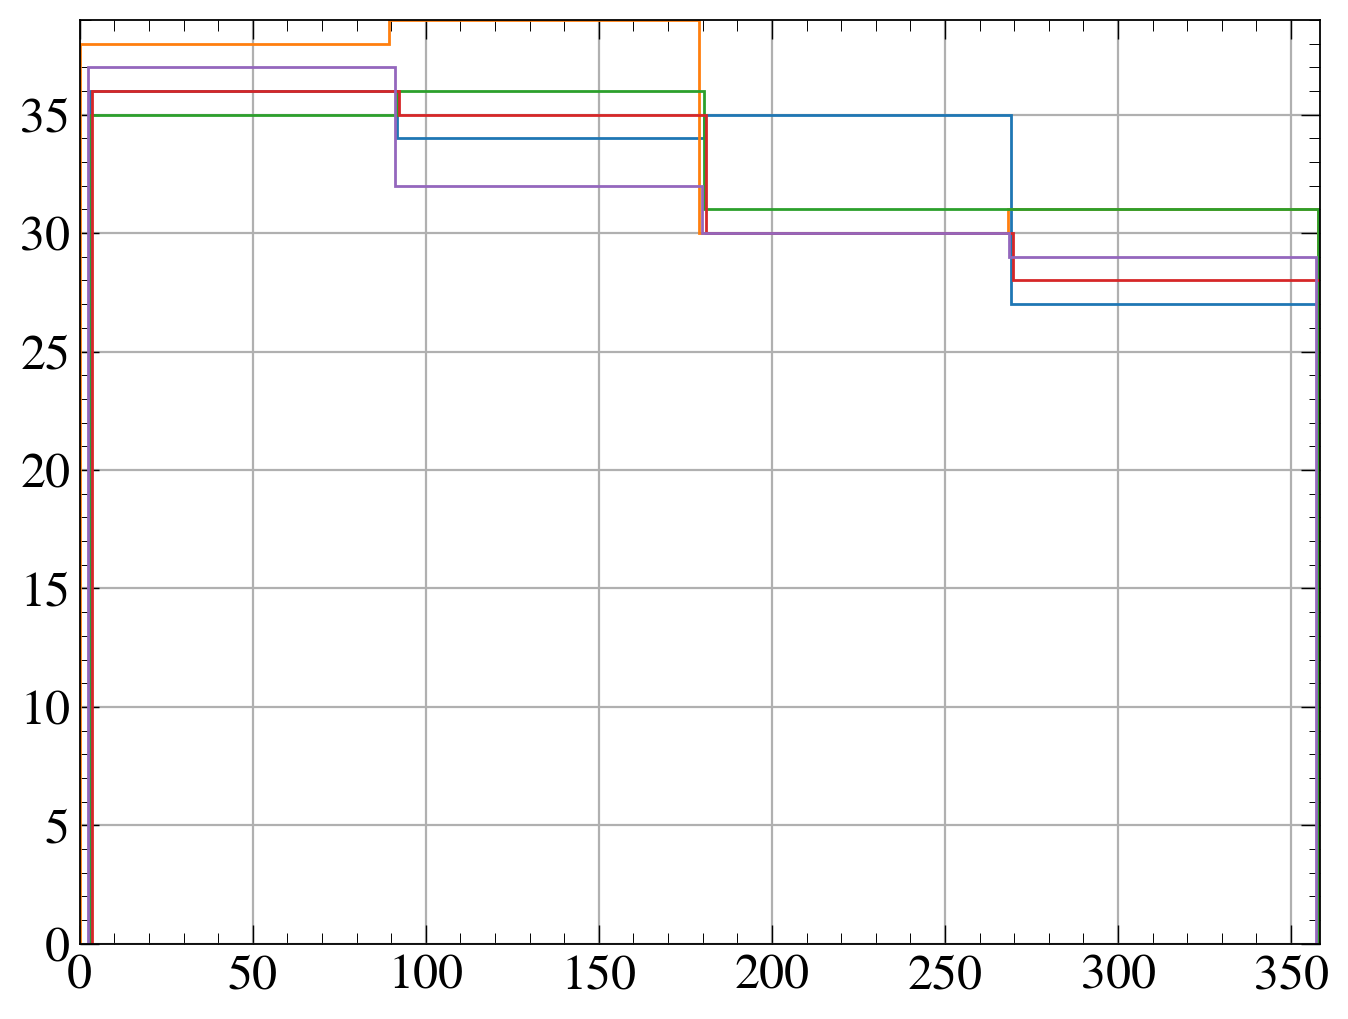

In [267]:
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(5):
    mdet_tables[i]["theta"] = calculate_angle(
        mdet_tables[i]["row"] - 255.0, mdet_tables[i]["col"] - 255.0
    )
    ax.hist(mdet_tables[i]["theta"], bins=4, histtype="step", label=f"{i}")

In [268]:
angular_binning = np.linspace(0,360.,5)
print(angular_binning)

[  0.  90. 180. 270. 360.]


In [269]:
# now estimate g1 in each radial bin
res_list = []

for i in range(len(pixel_radial_bin_edges) - 1):
    # for each mdet tables
    radial_masks = [
        (
            (mdet_tables[j]["row"] - mid) ** 2 + (mdet_tables[j]["col"] - mid) ** 2
            > pixel_radial_bin_edges[i] ** 2
        )
        & (
            (mdet_tables[j]["row"] - mid) ** 2 + (mdet_tables[j]["col"] - mid) ** 2
            < pixel_radial_bin_edges[i + 1] ** 2
        )
        for j in range(len(mdet_tables))
    ]

    for k in range(len(angular_binning) - 1):
        print(f"The angular range is {angular_binning[k]} to {angular_binning[k+1]}")
        angular_masks = [
            (mdet_tables[j]["theta"] > angular_binning[k])
            & (mdet_tables[j]["theta"] < angular_binning[k + 1])
            for j in range(len(mdet_tables))
        ]

        print(f"Radial bin {i} and angular bin {k}")
        res_list.append(_meas_shear_data(results, radial_masks, angular_masks))

The angular range is 0.0 to 90.0
Radial bin 0 and angular bin 0
There are 5 galaxies in the bin
theta max is 358.6433410644531
theta min is 2.7046477794647217
The angular range is 90.0 to 180.0
Radial bin 0 and angular bin 1
There are 4 galaxies in the bin
theta max is 358.6433410644531
theta min is 2.7046477794647217
The angular range is 180.0 to 270.0
Radial bin 0 and angular bin 2
There are 10 galaxies in the bin
theta max is 358.6433410644531
theta min is 2.7046477794647217
The angular range is 270.0 to 360.0
Radial bin 0 and angular bin 3
There are 3 galaxies in the bin
theta max is 358.6433410644531
theta min is 2.7046477794647217
The angular range is 0.0 to 90.0
Radial bin 1 and angular bin 0
There are 16 galaxies in the bin
theta max is 358.6433410644531
theta min is 2.7046477794647217
The angular range is 90.0 to 180.0
Radial bin 1 and angular bin 1
There are 11 galaxies in the bin
theta max is 358.6433410644531
theta min is 2.7046477794647217
The angular range is 180.0 to 270

In [271]:
angular_mid = (angular_binning[1:] + angular_binning[:-1]) / 2

def get_rt(R11, R12, R21, R22, theta):
    theta = np.radians(theta)
    return (
        R11 * np.cos(2 * theta) ** 2
        + R22 * np.sin(2 * theta) ** 2
        + (R12 + R21) * np.sin(2 * theta) * np.cos(2 * theta)
    )


def process_res(res_list, angular_binning, pixel_radial_bin_edges):
    mean_radial_result = []
    for i in range(len(pixel_radial_bin_edges) - 1):
        print(
            "This is radial bin",
            pixel_radial_bin_edges[i],
            pixel_radial_bin_edges[i + 1],
        )
        # for each mdet tables
        result_in_radial_bin = []
        for j in range(len(angular_binning) - 1):

            k = i * (len(angular_binning) - 1) + j
            res = res_list[k][0]
            mean_gt = res[2]
            print(f"Mean gt is {mean_gt}")
            R11, R12, R21, R22 = res[3], res[4], res[5], res[6]
            angle = angular_mid[j]
            Rt = get_rt(R11, R12, R21, R22, angle)
            print(f"Rt is {Rt}")
            correct_g = mean_gt / Rt
            result_in_radial_bin.append(correct_g)
        mean_radial_result.append(np.mean(result_in_radial_bin))
        print("-------------------------------------")
    return mean_radial_result

radial_res = process_res(res_list, angular_binning, pixel_radial_bin_edges)
print("The mean estimated shear are", radial_res)

This is radial bin 0 100
Mean gt is 0.10108554344789696
Rt is -0.04948150756783193
Mean gt is 0.013796979957632464
Rt is -1.3681998283243264
Mean gt is 0.11794489953149438
Rt is 0.9378065217693137
Mean gt is 0.15294499852830717
Rt is -1.8620182228507083
-------------------------------------
This is radial bin 100 200
Mean gt is 0.041964968625487466
Rt is 0.3354719867064816
Mean gt is 0.10339859685975773
Rt is 0.09659828187858087
Mean gt is 0.07229875654949534
Rt is 0.9433130179532538
Mean gt is 0.10681333067351356
Rt is 1.1791402832676767
-------------------------------------
This is radial bin 200 300
Mean gt is 0.07032602017924994
Rt is 0.8025228614044505
Mean gt is 0.08464107918121871
Rt is 0.33779807226765596
Mean gt is 0.09096211622808172
Rt is -0.4795529182904305
Mean gt is 0.05199478248371402
Rt is 0.1303095218951936
-------------------------------------
The mean estimated shear are [-0.5023380045450119, 0.3406798545437476, 0.1368817568308171]
